In [4]:
from replica_processor import *
import random

In [5]:
df = pd.read_csv('normed_nonanoms.csv', dtype={'x':'int8','y':'int8','ftag_id':'int8','occ':'float32','hist_type':'int8','hist_id':'int16','quality':'int8','occ_0to1':'float32','occ_zscore':'float32','occ_robust':'float32'})
df

,paths,x,y,occ,ftag_id,hist_type,hist_id,occ_0to1,occ_zscore,occ_robust,quality
0,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,0,0.0,0,0,0,0.0,-0.149630,-0.241575,0
1,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,1,0.0,0,0,0,0.0,-0.149630,-0.241575,0
2,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,2,0.0,0,0,0,0.0,-0.149630,-0.241575,0
3,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,3,0.0,0,0,0,0.0,-0.149630,-0.241575,0
4,run_363664/CaloMonitoring/ClusterMon/CaloCalTo...,0,4,0.0,0,0,0,0.0,-0.149630,-0.241575,0
...,...,...,...,...,...,...,...,...,...,...,...
41235475,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,60,0.0,84,17,233,0.0,-0.173805,-0.889612,0
41235476,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,61,0.0,84,17,233,0.0,-0.173805,-0.889612,0
41235477,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,62,0.0,84,17,233,0.0,-0.173805,-0.889612,0
41235478,run_360402/CaloMonitoring/ClusterMon/LArCluste...,98,63,0.0,84,17,233,0.0,-0.173805,-0.889612,0


In [6]:
def full_hist_split(main_dfs,train_set_pct):
    """
    On about 27million datapoints, took only 6-7mins
    
    Example Use:
        x_train,x_test = full_hist_split(main_dfs,.67)
    """
    
    try:
        del x_train_df
        del x_test_df
    except:
        pass

    for idf,ftid in enumerate(main_dfs['ftag_id'].unique()):

        # Progress
        progress_bar(idf,main_dfs['ftag_id'].unique())

        # Initialize randomized hist index lists
        rand_train_list = []
        rand_test_list = []

        print('setting up mask1 datapoints...')
        mask1 = main_dfs['ftag_id'] == ftid
        tmp = main_dfs.loc[mask1,:]

        # Gen rand_train_list for train_set
        print('generating rand_list...')
        while len(rand_train_list) < round(train_set_pct*len(tmp['hist_id'].unique())):
            rand_num = random.randint(0,len(tmp['hist_id'].unique())-1)
            if rand_num in rand_train_list:
                continue
            rand_train_list.append(rand_num)

        # Gen rand_test_list for train_set
        while len(rand_test_list) < round((1-train_set_pct)*len(tmp['hist_id'].unique())):
            rand_num = random.randint(0,len(tmp['hist_id'].unique())-1)
            if rand_num in rand_train_list or rand_num in rand_test_list:
                continue
            rand_test_list.append(rand_num)

        # Build the training set
        
        print('setting up mask2 datapoints...')
        mask2 = tmp['hist_id'].isin(rand_train_list)
        tmp2 = tmp.loc[mask2,:]
        
        print('updating dataframe...')
        try:
            x_train_df = pd.concat([x_train_df,tmp2])
        except:
            x_train_df = tmp2

        # Build the test set
        
        print('setting up mask2 datapoints...')
        mask2 = tmp['hist_id'].isin(rand_test_list)
        tmp2 = tmp.loc[mask2,:]
        
        print('updating dataframe...')
        try:
            x_test_df = pd.concat([x_test_df,tmp2])
        except:
            x_test_df = tmp2
            
    return x_train_df, x_test_df

In [7]:
x_train_noanom_df,x_test_noanom_df = full_hist_split(df,.67)

Processing file 83 of 83 files... 100.0% Complete
setting up mask1 datapoints...
generating rand_list...
setting up mask2 datapoints...
updating dataframe...
setting up mask2 datapoints...
updating dataframe...


In [8]:
x_train_noanom_df['quality'].value_counts()

0    27593280
Name: quality, dtype: int64

In [9]:
x_test_noanom_df['quality'].value_counts()

0    13642200
Name: quality, dtype: int64

In [10]:
tmp = x_train_noanom_df[x_train_noanom_df['quality']==1]
tmp = tmp[tmp['ftag_id']==7]
tmp = tmp[tmp['hist_id']==2]
tmp

,paths,x,y,occ,ftag_id,hist_type,hist_id,occ_0to1,occ_zscore,occ_robust,quality


In [54]:
# How many histograms do we have that are invalid (all occ values are 0)
cnt=0
for ftag in x_train_noanom_df['ftag_id'].unique():
    tmp = x_train_noanom_df[x_train_noanom_df['ftag_id']==ftag]
    for histid in x_train_noanom_df[x_train_noanom_df['ftag_id']==ftag]['hist_id'].unique():
        tmp2 = tmp[tmp['hist_id']==histid]
        if len(tmp2['occ'].value_counts().values)==1:
            cnt+=1
#             print(ftag,histid)
#             input_heatmap(x_train_noanom_df,ftag,histid)
#             plt.show()
cnt

123

In [55]:
# How many histograms do we have that are invalid (all occ values are 0) for the test set
cnt=0
for ftag in x_test_noanom_df['ftag_id'].unique():
    tmp = x_test_noanom_df[x_test_noanom_df['ftag_id']==ftag]
    for histid in x_test_noanom_df[x_test_noanom_df['ftag_id']==ftag]['hist_id'].unique():
        tmp2 = tmp[tmp['hist_id']==histid]
        if len(tmp2['occ'].value_counts().values)==1:
            cnt+=1
#             print(ftag,histid)
#             input_heatmap(x_train_noanom_df,ftag,histid)
#             plt.show()
cnt

57

In [58]:
# How many histograms total do we have in this dataset
cnt=0
for ftag in df['ftag_id'].unique():
    tmp = df[df['ftag_id']==ftag]
    for histid in tmp[tmp['ftag_id']==ftag]['hist_id'].unique():
        tmp2 = tmp[tmp['hist_id']==histid]
        cnt+=1
cnt

6408

In [11]:
def input_heatmap(df,ftag_id,hist_id):
    tmp = df[df['ftag_id']==ftag_id]
    tmp = tmp[tmp['hist_id']==hist_id]
    sns.heatmap( tmp.pivot_table(index='y',columns='x',values='occ') )

<IPython.core.display.Javascript object>

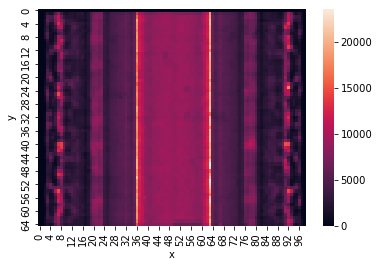

In [40]:
# This is the monitoring histogram in its unaltered form (non noisy, no generated anomalous data)
input_heatmap(x_test_noanom_df,0,1)

In [13]:
x_train_noanom_df.to_csv('x_train_noanom_df.csv',index=False)
x_test_noanom_df.to_csv('x_test_noanom_df.csv',index=False)